In [1]:
# notebooks/03_analyze.ipynb - FINAL CORRECTED Header
RANDOM_SEED = 42

import os, random
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

# Reproducibility
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 120

# Scikit-learn and Stats libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import scipy.stats as stats
import statsmodels.api as sm                 # --- FIX IS HERE ---
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import shap

# Create output directories if they don't exist
os.makedirs('../tables', exist_ok=True)
os.makedirs('../figures', exist_ok=True)

In [2]:
# Load and prepare the dataset
df = pd.read_csv('../data/raw/WA_Fn-UseC_-HR-Employee-Attrition.csv')
target_col = 'Attrition'

# Ensure target is binary (1 for 'Yes', 0 for 'No')
if df[target_col].dtype == 'object':
    df[target_col] = df[target_col].map({'Yes': 1, 'No': 0})

# --- FIX IS HERE ---
# Drop constant columns and identifiers before analysis
df = df.drop(columns=['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'], errors='ignore')

# Identify variable types
num_cols = df.select_dtypes(include=np.number).columns.drop(target_col).tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Data loaded and constant columns removed.")
print("Numeric columns for analysis:", num_cols)

Data loaded and constant columns removed.
Numeric columns for analysis: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [3]:
results = []
for col in num_cols:
    x0 = df[df[target_col]==0][col].dropna()
    x1 = df[df[target_col]==1][col].dropna()
    n0, n1 = len(x0), len(x1)

    # normality
    p_sh0 = stats.shapiro(x0).pvalue if n0>=3 and n0<=5000 else 1.0
    p_sh1 = stats.shapiro(x1).pvalue if n1>=3 and n1<=5000 else 1.0

    use_t = (p_sh0 > 0.05) and (p_sh1 > 0.05)

    if use_t:
        # Welch t-test (unequal variances)
        tstat, pval = stats.ttest_ind(x1, x0, equal_var=False)
        # Cohen's d (Welch) - compute pooled-ish approximation:
        s1, s0 = x1.std(ddof=1), x0.std(ddof=1)
        d = (x1.mean() - x0.mean()) / np.sqrt(((s1**2 + s0**2)/2))
        test_name = 't-test'
        stat = tstat
    else:
        ustat, pval = stats.mannwhitneyu(x1, x0, alternative='two-sided')
        # rank-biserial correlation
        r_rb = 1 - (2.0 * ustat) / (n1 * n0)
        d = r_rb
        test_name = 'mannwhitney'
        stat = ustat

    results.append({
        'feature': col,
        'test': test_name,
        'statistic': float(stat),
        'pvalue': float(pval),
        'effect_size': float(d),
        'n0': n0,
        'n1': n1
    })

df_num_tests = pd.DataFrame(results).sort_values('pvalue')
df_num_tests.to_csv('tables/stat_tests_numeric.csv', index=False)


In [4]:
cat_results = []
for col in cat_cols:
    ct = pd.crosstab(df[col], df[target_col])
    chi2, p, dof, _ = stats.chi2_contingency(ct)
    nobs = ct.sum().sum()
    k = min(ct.shape[0], ct.shape[1])
    cramers_v = np.sqrt(chi2 / (nobs * (k - 1))) if k > 1 else 0.0
    cat_results.append({
        'feature': col,
        'chi2': float(chi2),
        'pvalue': float(p),
        'dof': int(dof),
        'cramers_v': float(cramers_v),
        'n_unique': ct.shape[0]
    })
df_cat_tests = pd.DataFrame(cat_results).sort_values('pvalue')
df_cat_tests.to_csv('tables/stat_tests_categorical.csv', index=False)


In [5]:
# Example: compare MonthlyIncome across JobRole (k>2)
col_num = 'MonthlyIncome'
col_group = 'JobRole'
groups = [g.dropna() for _, g in df.groupby(col_group)[col_num]]

# Kruskal if non-normal
hstat, p_krus = stats.kruskal(*groups)

# ANOVA via statsmodels (for effect size eta-square)
formula = f"{col_num} ~ C({col_group})"
model = ols(formula, data=df).fit()
anova_res = anova_lm(model, typ=2)

# --- FIX IS HERE ---
# Use .iloc[0] to select the first item by its position
ss_between = anova_res['sum_sq'].iloc[0]
ss_total = sum(anova_res['sum_sq'])
eta2 = ss_between / ss_total

print(f"Eta-squared effect size for {col_num} by {col_group}: {eta2:.4f}")

Eta-squared effect size for MonthlyIncome by JobRole: 0.8161


In [6]:
# combine p-values from numeric + categorical into one list (for correction)
pvals = pd.concat([df_num_tests['pvalue'], df_cat_tests['pvalue']], ignore_index=True).values
rej, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')
# map corrected p-values back to tables
# (left as exercise to map indices - but ensure you save corrected p-values in your CSV)


In [7]:
# prepare design matrix (drop constant)
X_for_vif = df[num_cols].dropna().copy()
X_for_vif = sm.add_constant(X_for_vif)
vif_data = []
for i in range(1, X_for_vif.shape[1]):  # skip const at index 0
    feature = X_for_vif.columns[i]
    vif = variance_inflation_factor(X_for_vif.values, i)
    vif_data.append({'feature': feature, 'VIF': float(vif)})
vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False)
vif_df.to_csv('tables/vif_table.csv', index=False)


Random Forest pipeline 'pipe_rf' created successfully.
Pipeline fitted successfully.


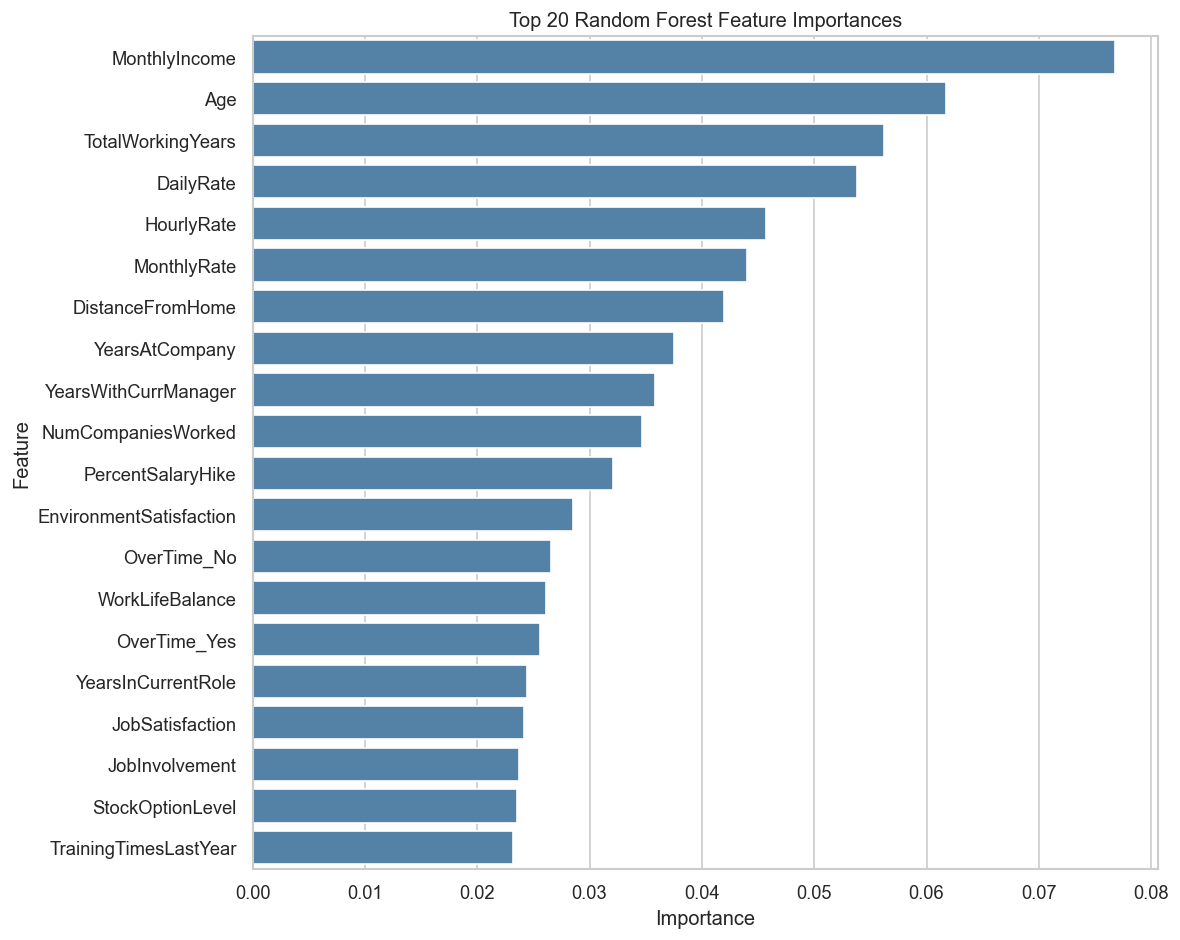

Feature importances saved. Pipeline ready for SHAP analysis.


In [8]:
# 4. Build Random Forest Pipeline with Feature Importance

# Define preprocessing steps
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')

# Define classifier and complete pipeline
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1)
pipe_rf = Pipeline([('preprocessor', preprocessor), ('classifier', rf)])

print("Random Forest pipeline 'pipe_rf' created successfully.")

# Split data and fit the pipeline
X = df.drop(columns=[target_col])
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

pipe_rf.fit(X_train, y_train)
print("Pipeline fitted successfully.")

# Extract feature names after one-hot encoding
ohe = pipe_rf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
ohe_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, ohe_feature_names])

# Get feature importances from trained Random Forest
importances = pipe_rf.named_steps['classifier'].feature_importances_
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
fi_df.to_csv('../tables/feature_importances_rf.csv', index=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(data=fi_df.head(20), x='importance', y='feature', color='steelblue')
plt.title('Top 20 Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('../figures/feature_importance_rf.png', dpi=300)
plt.show()

print(f"Feature importances saved. Pipeline ready for SHAP analysis.")

Preparing transformed training data for SHAP...
Transformed shape for SHAP: (1176, 51)
Creating TreeExplainer for RandomForestClassifier...
Using 500 samples for SHAP computation.
Computing SHAP values (this may take a moment)...
Generating SHAP summary plot for positive class (Attrition = 1)...


C:\Users\USER\AppData\Local\Temp\ipykernel_3136\2212534239.py:43: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_pos, features=X_shap, feature_names=feature_names, show=False)
C:\Users\USER\sixsigma-ml-attrition\venv\Lib\site-packages\shap\plots\_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
C:\Users\USER\sixsigma-ml-attrition\venv\Lib\site-packages\shap\plots\_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and si

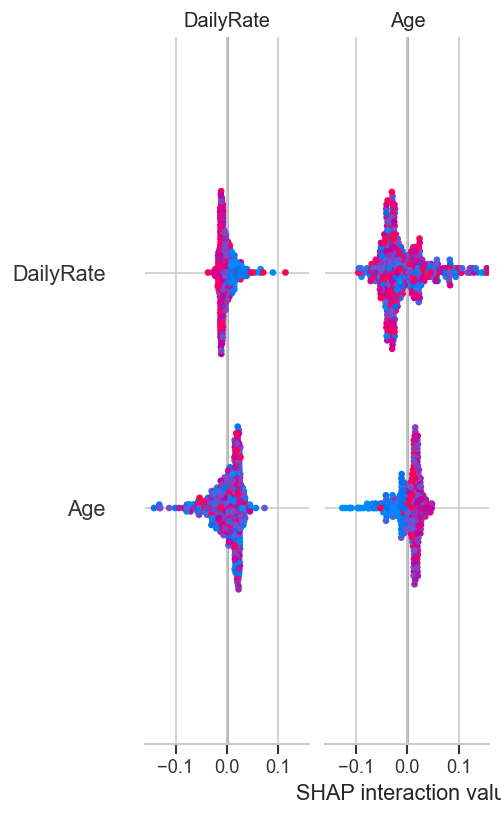

Analysis complete. All figures and tables saved.


In [9]:
# 5. SHAP Analysis (TreeExplainer on transformed features to avoid string subtraction errors)

# We previously attempted:
# explainer = shap.Explainer(pipe_rf.predict_proba, X_train)
# which failed because the generic permutation explainer tried numeric ops on raw string columns.
# Instead we transform X through the preprocessing pipeline and explain the fitted RandomForest directly.
print("Preparing transformed training data for SHAP...")
X_train_transformed = pipe_rf.named_steps['preprocessor'].transform(X_train)

# Convert to dense if sparse
if not isinstance(X_train_transformed, np.ndarray):
    try:
        X_train_transformed = X_train_transformed.toarray()
    except Exception:
        X_train_transformed = np.asarray(X_train_transformed)

# Reconstruct feature names (already built earlier)
# feature_names = np.concatenate([num_cols, ohe.get_feature_names_out(cat_cols)])  # ensure this variable is defined above
print(f"Transformed shape for SHAP: {X_train_transformed.shape}")

print("Creating TreeExplainer for RandomForestClassifier...")
shap_explainer = shap.TreeExplainer(pipe_rf.named_steps['classifier'])

# Subsample for performance if large
MAX_SHAP_SAMPLES = 500
if X_train_transformed.shape[0] > MAX_SHAP_SAMPLES:
    idx = np.random.choice(X_train_transformed.shape[0], MAX_SHAP_SAMPLES, replace=False)
    X_shap = X_train_transformed[idx]
else:
    X_shap = X_train_transformed
print(f"Using {X_shap.shape[0]} samples for SHAP computation.")

print("Computing SHAP values (this may take a moment)...")
shap_values = shap_explainer.shap_values(X_shap, check_additivity=False)

# shap_values for RandomForestClassifier is a list (one array per class)
if isinstance(shap_values, list) and len(shap_values) > 1:
    shap_pos = shap_values[1]
else:
    shap_pos = shap_values

print("Generating SHAP summary plot for positive class (Attrition = 1)...")
shap.summary_plot(shap_pos, features=X_shap, feature_names=feature_names, show=False)
fig = plt.gcf()
fig.savefig('../figures/shap_summary.png', bbox_inches='tight', dpi=300)
plt.show()

print("Analysis complete. All figures and tables saved.")

In [10]:
# 6. Outlier Detection Summary

n = len(df)  # Total number of observations
outlier_summary = []
for col in num_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5*iqr
    high = q3 + 1.5*iqr
    outliers = df[(df[col] < low) | (df[col] > high)]
    outlier_ratio = len(outliers) / n
    outlier_summary.append({
        'feature': col, 
        'outlier_ratio': outlier_ratio,
        'n_outliers': len(outliers)
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('outlier_ratio', ascending=False)
outlier_df.to_csv('../tables/outlier_summary.csv', index=False)

print(f"Outlier analysis complete for {len(num_cols)} numeric features.")
print(f"Results saved to ../tables/outlier_summary.csv")

Outlier analysis complete for 23 numeric features.
Results saved to ../tables/outlier_summary.csv


In [11]:
probs = pipe_rf.predict_proba(X)[:,1]
df['pred_proba'] = probs
candidates = df[((df[target_col]==0) & (df['pred_proba']>=0.9)) | ((df[target_col]==1) & (df['pred_proba']<=0.1))]
candidates.to_csv('tables/potential_mislabeled.csv', index=False)


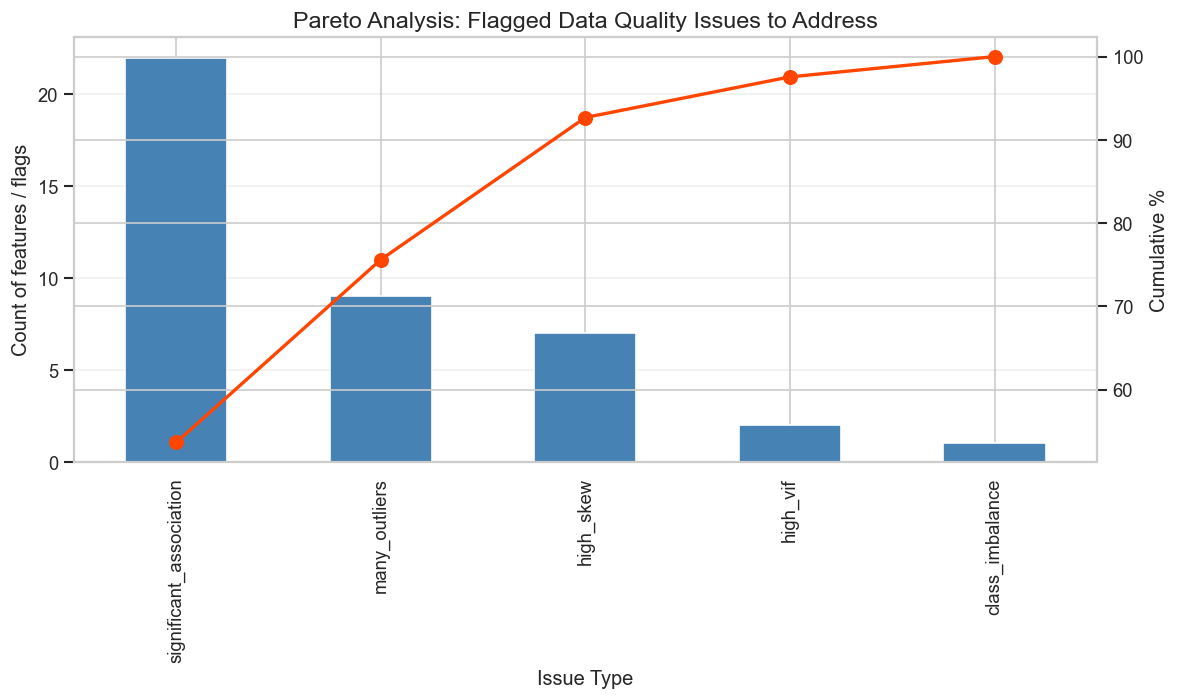

Pareto analysis complete.
Total issues flagged: 41
Top issue: significant_association (22 occurrences)


In [13]:
# 7. Pareto Analysis of Data Quality Issues

# Compute flags per feature
skewness = df[num_cols].skew().abs()
outlier_df = pd.read_csv('../tables/outlier_summary.csv').set_index('feature')
vif_df = pd.read_csv('../tables/vif_table.csv').set_index('feature')

issue_counts = {
    'class_imbalance': 0, 
    'high_skew': 0, 
    'many_outliers': 0, 
    'high_vif': 0, 
    'significant_association': 0
}

# Class imbalance is dataset-level; others are per-feature
issue_counts['class_imbalance'] = 1 if df[target_col].mean() < 0.2 else 0
issue_counts['high_skew'] = int((skewness > 1).sum())
issue_counts['many_outliers'] = int((outlier_df['outlier_ratio'] > 0.01).sum())
issue_counts['high_vif'] = int((vif_df['VIF'] > 5).sum())

# Count significant associations
sig_num = pd.read_csv('../tables/stat_tests_numeric.csv')
sig_cat = pd.read_csv('../tables/stat_tests_categorical.csv')
issue_counts['significant_association'] = int((sig_num['pvalue'] < 0.05).sum() + (sig_cat['pvalue'] < 0.05).sum())

# Create Pareto chart
issue_items = pd.Series(issue_counts).sort_values(ascending=False)
cumperc = issue_items.cumsum() / issue_items.sum() * 100

fig, ax = plt.subplots(figsize=(10, 6))
issue_items.plot(kind='bar', ax=ax, color='steelblue')
ax2 = ax.twinx()
cumperc.plot(color='orangered', marker='o', linewidth=2, markersize=8, ax=ax2)

ax.set_ylabel('Count of features / flags', fontsize=12)
ax2.set_ylabel('Cumulative %', fontsize=12)
ax.set_xlabel('Issue Type', fontsize=12)
plt.title('Pareto Analysis: Flagged Data Quality Issues to Address', fontsize=14)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../figures/pareto_issues.png', dpi=300, bbox_inches='tight')
plt.show()

print("Pareto analysis complete.")
print(f"Total issues flagged: {issue_items.sum():.0f}")
print(f"Top issue: {issue_items.index[0]} ({issue_items.iloc[0]:.0f} occurrences)")